<a href="https://colab.research.google.com/github/Siddharth-Singh-2004/PyTorchFunctionality/blob/main/PyTorchFunctionalities.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
import math
import torch
import random
import numpy as np
import matplotlib.pyplot as plt

In [3]:
!pip install torch

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

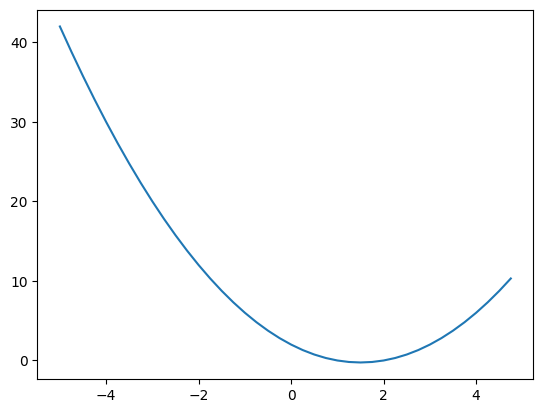

In [24]:
# Defining a function
def f(x):
  return x**2 - 3*x + 2

# Plotting the function
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [27]:
# Calculating gradient of the function
x = 3/2
h = 0.0001
(f(x+h) - f(x))/h

9.99999993922529e-05

Implementing with PyTorch

In [30]:
# Multi-variate functions
a = 3
b = 2
c = 7
d = a*(b**2) + c

h = 0.0001

# Calculating dd/db
b += h
d2 = a*(b**2) + c
(d2 - d)/h

12.000300000032382

In [34]:
# Defining a Value class to carry out backpropogation
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int and float powers"
    out = Value(self.data**other.data, (self,), f'**{other}')
    return out

  def __rmul__(self, other):
    return self * other

  def __truediv__(self, other):
    return self * other ** -1

  def __neg__(self):
    return self * -1

  def __sub__(self, other):
    return self - other

  def __radd__(self, other):
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self,), 'tanh')
    return out


In [31]:
x1 = torch.tensor([1.0]).double(); x1.requires_grad = True
w1 = torch.tensor([5.0]).double(); w1.requires_grad = True
x2 = torch.tensor([2.0]).double(); x2.requires_grad = True
w2 = torch.tensor([3.0]).double(); w2.requires_grad = True
b = torch.tensor([4.0]).double(); b.requires_grad = True
o = x1 * w1 + x2 * w2 + b
print(o.data)
o.backward()

print(x1.grad.data)
print(w1.data)
print(x2.data)
print(w2.data)


tensor([15.], dtype=torch.float64)
tensor([5.], dtype=torch.float64)
tensor([5.], dtype=torch.float64)
tensor([2.], dtype=torch.float64)
tensor([3.], dtype=torch.float64)


In [9]:
# Creating a neuron
class Neuron:

  def __init__(self, n_in):
    self.w = torch.tensor([random.uniform(-1, 1) for _ in range(n_in)]); self.w.requires_grad = True
    self.b = torch.tensor(random.uniform(-1, 1)); self.b.requires_grad = True

  def __call__(self, x):
    x = x.clone().detach().requires_grad_(True)
    activation = torch.dot(self.w, x) + self.b
    output = torch.tanh(activation)
    return output

  def parameters(self):
    return [self.w + self.b]

# Creating a layer
class Layer:

  def __init__(self, n_in, n_out):
    self.neurons = [Neuron(n_in) for _ in range(n_out)]

  def __call__(self, x):
    outputs = [n(x) for n in self.neurons]
    return outputs[0] if len(outputs) == 1 else torch.stack(outputs)

  def parameters(self):
    params = []
    for neuron in self.neurons:
      params.extend(neuron.parameters())
    return params

# Creating a multi-layer perceptron
class MLP:

  def __init__(self, n_in, n_outs):
    size = [n_in] + n_outs
    self.layers = [Layer(size[i], size[i+1]) for i in range(len(n_outs))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    params = []
    for layer in self.layers:
      params.extend(layer.parameters())
    return params

x = torch.tensor([2.0, 3.0, 5.0])
n = MLP(3, [4, 5, 1])
n(x)

tensor(-0.4075, grad_fn=<TanhBackward0>)

In [6]:
# Creating a sample dataset
xs = torch.tensor([
    [2.0, 3.0, -1.0],
    [3.0, 4.0, 7.0],
    [-2.0, 1.0, 9.0],
    [3.0, -4.0, -1.0]
], dtype=torch.float32)

# Its desired outputs
ys = torch.tensor([1.0, -1.0, -1.0, 1.0], dtype=torch.float32)

# Predicted outputs
ypred = torch.tensor([n(x) for x in xs], dtype=torch.float32)
ypred

tensor([ 0.4324,  0.5489, -0.2028, -0.1871])

In [7]:
# Defining squared loss
loss = torch.tensor([torch.sum(torch.stack([(torch.tensor(yout) - ypred[i])**2 for i, yout in enumerate(ys)]))])
loss

<ipython-input-7-f1c8747290f2>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.tensor([torch.sum(torch.stack([(torch.tensor(yout) - ypred[i])**2 for i, yout in enumerate(ys)]))])


tensor([4.7659])

In [10]:
for p in n.parameters():
  p.grad = 0

TypeError: assigned grad expected to be a Tensor or None but got grad of type int

In [175]:
loss.backward()

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [118]:
# Display the gradients
for param in n.parameters():
    print(param.grad)

None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
tensor([2.0069, 1.1945, 0.2677, 1.3141, 0.7149])
tensor(2.1307)
